# README
This notebook is shared FOR REFERENCE ONLY, as supporting material for the paper "Ubiquity of human-induced changes in climate variability", Rodger et al, Earth System Dynamics, 2021.
(https://doi.org/10.5194/esd-2021-50)

The notebook creates Figure 4 in the main text. It calculates the CESM2 LENS ensemble standard deviationa of surface temperature and precipitation for the DJF season and periods 1960-1989 and 2070-2099, and calculates the statistical significance of the difference between the two periods using a modified Welch's t-test to account for both serial correlation and heteroskedasticity. Additionally, it plots the ensemble correlations of the Niño3.4 index with surface temperature and preciptiation for the same periods, as calculated by Tamas Bodai (see his m-files in this directory).

For questions regarding this notebook, please email the author, Karl Stein at:
iccp[DOT]stein[AT]gmail[DOT]com

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/kstein/MPI/scheduler.json')

In [2]:
client

Client Scheduler: tcp://203.247.189.225:37527 Dashboard: http://203.247.189.225:8742/status,Cluster Workers: 5 Cores: 180 Memory: 139.70 GiB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import glob
import pop_tools

In [4]:
def process_coords(ds, concat_dim='time', drop=True, extra_coord_vars=['time_bound']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = [v for v in ds.data_vars if concat_dim not in ds[v].dims]
    for ecv in extra_coord_vars:
        if ecv in ds:
            coord_vars += extra_coord_vars
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
from cartopy.util import add_cyclic_point
def xr_add_cyclic_point(da,tname=None):
    """
    Inputs
    da: xr.DataArray with dimensions (tname,lat,lon)
    
    """
    
    # Use add_cyclic_point to interpolate input data
    lon_idx = da.dims.index('lon')
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon, axis=lon_idx)
    # Generate output DataArray with new data but same structure as input
    if tname!=None :
        outp_da = xr.DataArray(data=wrap_data,
                               coords = { tname: da[tname], 'lat': da.lat, 'lon': wrap_lon},
                               dims=da.dims,
                               attrs=da.attrs)
    else :
        outp_da = xr.DataArray(data=wrap_data,
                               coords = {'lat': da.lat, 'lon': wrap_lon},
                               dims=da.dims,
                               attrs=da.attrs)
    return outp_da

In [6]:
def load_CESM_lens_ds(ensemble_names,domain,freq,var):
    
    import glob
    import xarray as xr
   
    ens_dir = '/proj/jedwards/archive/'
    
    ens_files = []
    for ens_name in ensemble_names:
        datadir = ens_dir  + ens_name + '/' + domain + '/proc/tseries/' + freq + '/'
        ncfiles = glob.glob(datadir + ens_name + '.*.' + var + '.*.nc')

        files = [ncfile for ncfile in sorted(ncfiles)]
        ens_files.append(files)

    ds = xr.open_mfdataset(ens_files,
                                    combine='nested',
                                    concat_dim=[[*ens_numbers],'time'],
                                    preprocess=process_coords,
                                    parallel='True',
                                    decode_cf = False,
                                    decode_times = False)
    ds = ds.rename({'concat_dim' : 'ensemble'})
    return ds

In [7]:
proj_dir = '/proj/kstein/CESM2_LE/Presentation_paper/'
ens_dir = '/proj/jedwards/archive/'

ens_numbers = []
hist_ens_names = []
ssp_ens_names = []

# initial macro ensemble members
ic_times = range(1001,1202,20)
members = range(1,11)

macro_members = [str(ic_times[ind]) + '.' + str(members[ind]).zfill(3) for ind in range(10)]
ens_numbers.extend(macro_members)

hist_macro_names =['b.e21.BHISTcmip6.f09_g17.LE2-' + n for n in macro_members]
ssp_macro_names =['b.e21.BSSP370cmip6.f09_g17.LE2-' + n for n in macro_members]

hist_ens_names.extend(hist_macro_names)
ssp_ens_names.extend(ssp_macro_names)

# micro ensembles
ic_times = (1231,1251,1281,1301)

members = range(1,11)

cmip6_micro_members = [str(ict) + '.' + str(m).zfill(3) for ict in ic_times for m in members]
ens_numbers.extend(cmip6_micro_members)

hist_cmip6_ens_names = ['b.e21.BHISTcmip6.f09_g17.LE2-' + n for n in cmip6_micro_members]
ssp_cmip6_ens_names = ['b.e21.BSSP370cmip6.f09_g17.LE2-' + n for n in cmip6_micro_members]

hist_ens_names.extend(hist_cmip6_ens_names)
ssp_ens_names.extend(ssp_cmip6_ens_names)

members = range(11,21)
smbb_micro_members = [str(ict) + '.' + str(m).zfill(3) for ict in ic_times for m in members]
ens_numbers.extend(smbb_micro_members)

hist_smbb_ens_names = ['b.e21.BHISTsmbb.f09_g17.LE2-' + n for n in smbb_micro_members]
ssp_smbb_ens_names = ['b.e21.BSSP370smbb.f09_g17.LE2-' + n for n in smbb_micro_members]

hist_ens_names.extend(hist_smbb_ens_names)
ssp_ens_names.extend(ssp_smbb_ens_names)

# MOAR members

ic_times = range(1011,1201,20)
members = range(1,11)

moar_members = [str(ic_times[ind]) + '.' + str(members[ind]).zfill(3) for ind in range(10)]
ens_numbers.extend(moar_members)

hist_moar_names =['b.e21.BHISTsmbb.f09_g17.LE2-' + n for n in moar_members]
ssp_moar_names =['b.e21.BSSP370smbb.f09_g17.LE2-' + n for n in moar_members]

hist_ens_names.extend(hist_moar_names)
ssp_ens_names.extend(ssp_moar_names)

hist_ens_names = sorted(hist_ens_names)
ssp_ens_names = sorted(ssp_ens_names)

# Load data

In [8]:
cc_P_file = 'ENSO_IM_teleco_presentation_2intervals_P_DJF.nc'
cc_T_file = 'ENSO_IM_teleco_presentation_2intervals_TS_DJF.nc'
cc_P_da = xr.open_dataset(proj_dir + '/output/' + cc_P_file)
cc_T_da = xr.open_dataset(proj_dir + '/output/' + cc_T_file)

In [9]:
cc_T_da

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288)
Coordinates:
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    cc_ave_1  (lat, lon) float64 ...
    cc_ave_2  (lat, lon) float64 ...
    pt        (lat, lon) float64 ...
    sd_ave_1  (lat, lon) float64 ...
    sd_ave_2  (lat, lon) float64 ...

In [10]:
domain = 'atm'
freq = 'month_1'
var = 'TS'

hist_ts_ds = load_CESM_lens_ds(hist_ens_names,domain,freq,var)
hist_ts_ds['time'] = xr.cftime_range(start='1850-01-01',
                                       end = '2014-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
hist_ts_da = hist_ts_ds[var] - 273.15

ssp_ts_ds = load_CESM_lens_ds(ssp_ens_names,domain,freq,var)
ssp_ts_ds['time'] = xr.cftime_range(start='2015-01-01',
                                       end = '2100-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
ssp_ts_da = ssp_ts_ds[var] - 273.15

In [11]:
domain = 'atm'
freq = 'month_1'
var = 'PRECT'

hist_p_ds = load_CESM_lens_ds(hist_ens_names,domain,freq,var)
hist_p_ds['time'] = xr.cftime_range(start='1850-01-01',
                                       end = '2014-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
hist_p_da = hist_p_ds[var]

ssp_p_ds = load_CESM_lens_ds(ssp_ens_names,domain,freq,var)
ssp_p_ds['time'] = xr.cftime_range(start='2015-01-01',
                                       end = '2100-12-31',
                                       freq = 'M',
                                       calendar = 'noleap')
ssp_p_da = ssp_p_ds[var]

In [12]:
ssp_p_da

,Array,Chunk
Bytes,21.26 GiB,25.31 MiB
Shape,"(100, 1032, 192, 288)","(1, 120, 192, 288)"
Count,4500 Tasks,900 Chunks
Type,float32,numpy.ndarray


In [13]:
unit_con = 60*60*24*1000

hist_p_da = hist_p_da * unit_con
ssp_p_da = ssp_p_da * unit_con

In [14]:
def da_DJF_est(da,start_year,end_year):
    da_season = da.resample(time='QS-DEC').mean()
    da_DJF = da_season.where(da_season['time.month']==12, drop=True)
    da_DJF = da_DJF.sel(time=slice(str(start_year),str(end_year)))
    da_estd = da_DJF.std(dim='ensemble').compute()
    da_estd_tmean = da_estd.mean(dim='time').compute()
    
    return da_estd,da_estd_tmean

In [15]:
syr1, eyr1 = 1960, 1989
syr2, eyr2 = 2070, 2099

In [16]:
hist_ts,hist_ts_mean = da_DJF_est(hist_ts_da,syr1,eyr1)
ssp_ts,ssp_ts_mean = da_DJF_est(ssp_ts_da,syr2,eyr2)

diff_ts = 100*(ssp_ts_mean - hist_ts_mean)/hist_ts_mean

In [17]:
hist_p, hist_p_mean = da_DJF_est(hist_p_da,syr1,eyr1)
ssp_p, ssp_p_mean = da_DJF_est(ssp_p_da,syr2,eyr2)

diff_p = 100*(ssp_p_mean - hist_p_mean)/hist_p_mean

In [1]:
def calc_adjusted_welchs_pval_da(da1,da2):    
    import numpy as np
    from scipy import stats
    def calc_equivalent_sample_size(array):   
        L=len(array)
        
        for i in np.arange(1,L-2):
            x,y = array[:-i],array[i:]
            r,p = stats.pearsonr(x,y)
            if r <= np.exp(-1) :
                ess = float(L)//float(i)
                break
            if i == L - 3:
                ess = 1
                break
        return ess
    def calc_adjusted_welch_pval(array1,array2):
        
        from scipy import signal
        
        mu1,mu2=np.mean(array1,axis=0),np.mean(array2,axis=0)
        
        ts1=signal.detrend(array1,axis=0)
        ts2=signal.detrend(array2,axis=0)
        
        n1 = calc_equivalent_sample_size(ts1)
        n2 = calc_equivalent_sample_size(ts2)
        s1,s2=np.var(ts1,axis=0,ddof=1),np.var(ts2,axis=0,ddof=1)
        
        
        t=(mu1-mu2)/np.sqrt((s1/n1)+(s2/n2))
        dof=(s1/n1+s2/n2)**2/(((s1/n1)**2/(n1-1.))+((s2/n2)**2/(n2-1.)))
        p = 2 * stats.t.cdf(-np.abs(t), dof)
        
        return p
    
    T = len(da1.time)
    da1['time'] = range(T)
    da2['time'] = range(T)
        
    return xr.apply_ufunc(calc_adjusted_welch_pval, da1, da2,
                          vectorize = True,
                          input_core_dims=[['time'],['time']])

In [ ]:
ts_pval = calc_adjusted_welchs_pval_da(hist_ts,ssp_ts)

In [23]:
p_pval = calc_adjusted_welchs_pval_da(hist_p,ssp_p)

In [24]:
cc_T_diff = cc_T_da.cc_ave_2 - cc_T_da.cc_ave_1

In [25]:
cc_P_diff = cc_P_da.cc_ave_2 - cc_P_da.cc_ave_1

/home/kstein/miniconda3/envs/edge/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


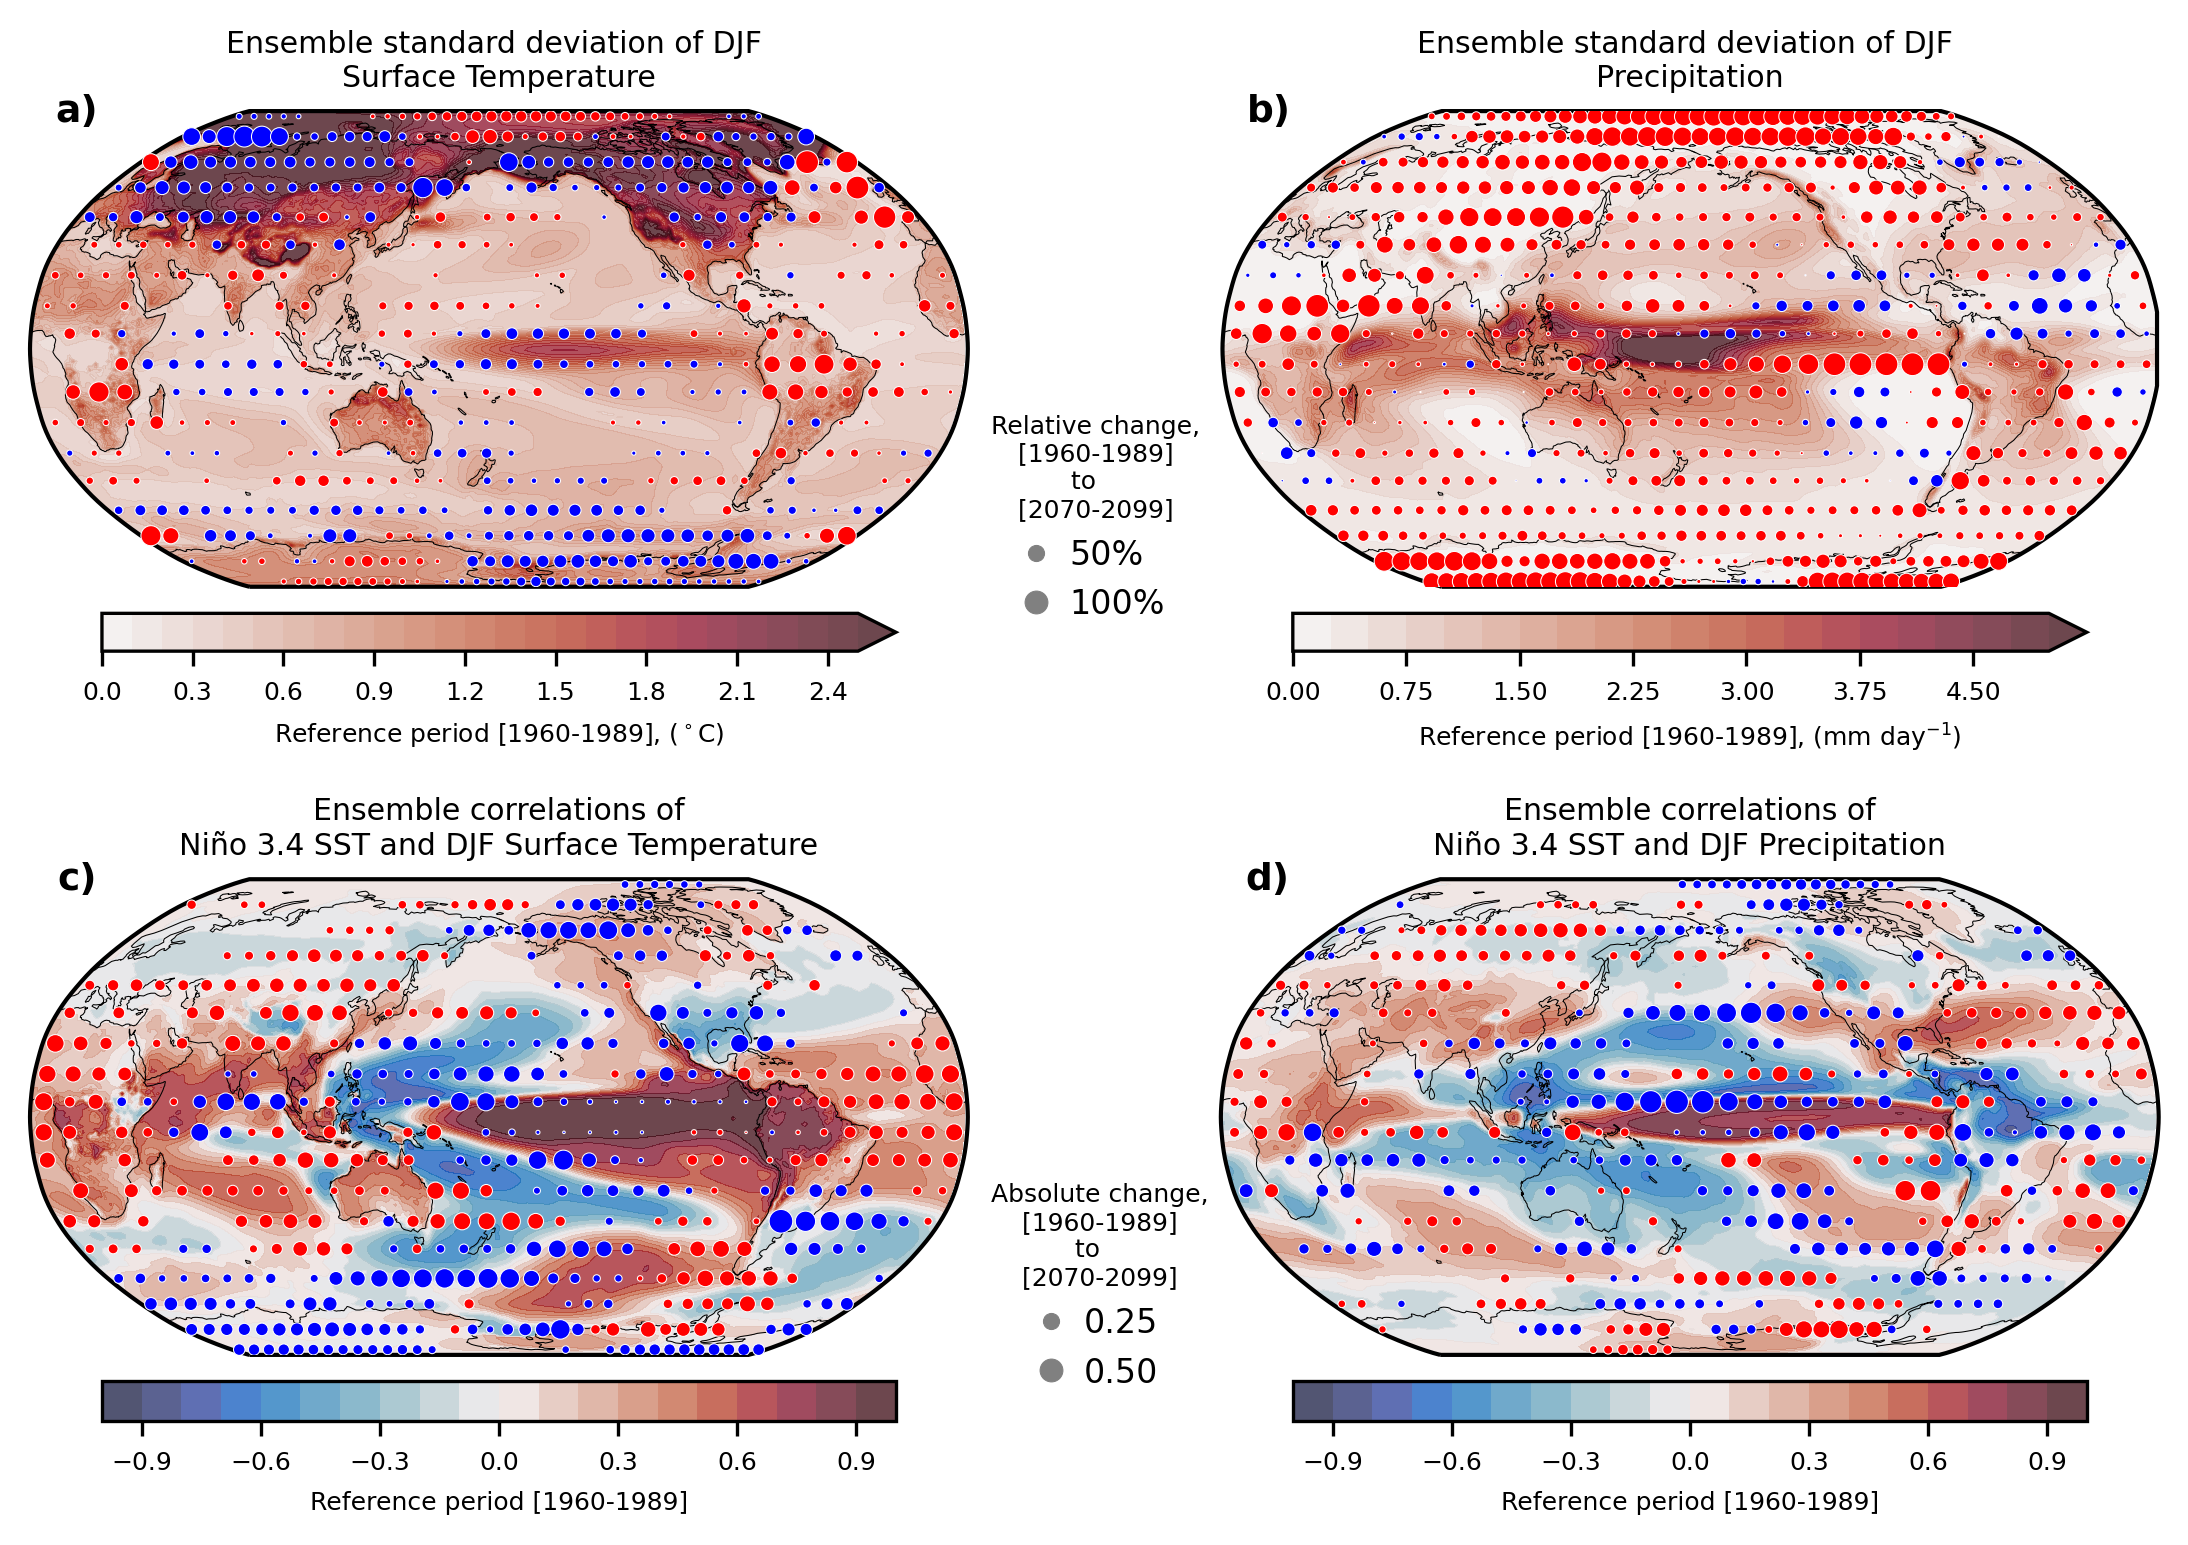

In [26]:
plot_fig = False
figtype = 'png'

cpos = 'Red'
cneg = 'Blue'

lat = hist_ts.lat.values
lon = hist_ts.lon.values

latind = np.arange(-85,90,10)
lonind = np.arange(5,360,10)
S = 30

P_cc_diff = cc_P_diff.where(cc_P_da.pt<.05)
P_cc_diff = P_cc_diff.sel(lat=latind,lon=lonind, method='nearest')


T_cc_diff = cc_T_diff.where(cc_T_da.pt<.05)
T_cc_diff = T_cc_diff.sel(lat=latind,lon=lonind, method='nearest')

T_diff = diff_ts.where(ts_pval<.05)
T_diff = T_diff.sel(lat=latind,lon=lonind, method='nearest')

P_diff = diff_p.where(p_pval<.05)
P_diff = diff_p.sel(lat=latind,lon=lonind, method='nearest')

Plim=100
P_diff.values[P_diff.values>Plim] = Plim
P_diff.values[P_diff.values<-Plim] = -Plim

Tlim=100
T_diff.values[T_diff.values>Tlim] = Tlim
T_diff.values[T_diff.values<-Tlim] = -Tlim

tfield = "Surface Temperature"
mmin,mmax,mdiff = 0, 2.5, .1
dmin,dmax,ddiff = -.5, .5, .05
tmlevs = np.arange(mmin, mmax+mdiff, mdiff)
tdlevs = np.arange(dmin, dmax+ddiff, ddiff)

pfield = "Precipitation"
mmin,mmax,mdiff = 0, 5, .25
dmin,dmax,ddiff = -80, 80, 10
pmlevs = np.arange(mmin, mmax+mdiff, mdiff)
pdlevs = np.arange(dmin, dmax+ddiff, ddiff)

mmin,mmax,mdiff = -1, 1, .1
dmin,dmax,ddiff = -.5, .5, .05
cmlevs = np.arange(mmin, mmax+mdiff, mdiff)
cdlevs = np.arange(dmin, dmax+ddiff, ddiff)

#-----------------------------------------------------------------------------------------------------


plt.rcParams.update({'font.size': 6})
fig1 = plt.figure(num=1,figsize=(10, 6), dpi=300,
                 #constrained_layout=True,
                 facecolor='w', edgecolor='k')

spec1 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig1,
                          wspace=0.05, hspace=0.3)

# TS std
#-----------------------------------------------------------------------------------------------------

ax1 = fig1.add_subplot(spec1[0, 0], projection=ccrs.Robinson(central_longitude=180))

ax1.set_global()

diff_da = T_diff
colors = np.where(diff_da<0, cneg, cpos)

X,Y = np.meshgrid(diff_da.lon, diff_da.lat)
scale=S/100
scatter = ax1.scatter(x=X, y = Y,
                 c=colors.ravel(),
                 s=np.abs(diff_da.values)*scale,
                  edgecolors='w',
                  linewidth=.25,
                  transform=ccrs.PlateCarree(),
                 zorder=10)

# Hacky solution to the legend bug:

sc1 = ax1.scatter([0,0], y = [0,1],
                 c=['gray','gray'],
                 s=[50*scale,100*scale],
                  edgecolors='w',
                  linewidth=.25,
                  transform=ccrs.PlateCarree(),
                 zorder=-10)

kw = dict(prop="sizes",
          num=[50,
               100],
          color='gray',
          fmt="{x:.0f}%",
          func=lambda s: s/scale)
legend = ax1.legend(*sc1.legend_elements(**kw),
                    loc=(0.985,-0.1),
                    fontsize=8,
                    frameon=False,
                    handletextpad=0.,
                   title='   Relative change,\n   [{}-{}]\n to \n   [{}-{}]'.format(syr1,eyr1,syr2,eyr2))
plt.setp(legend.get_title(), multialignment='center')


cl1m = hist_ts_mean.plot.contourf(add_colorbar=False,
             levels = tmlevs,
              alpha=.75,
             cmap = cmocean.cm.amp,
             transform=ccrs.PlateCarree())
ax1.coastlines(linewidth=.25)
ax1.set_title('Ensemble standard deviation of DJF \n' + tfield)

cb1m = plt.colorbar(cl1m,ax=[ax1],
                   location='bottom',
                  shrink=.7,
                  pad=.045)
cb1m.set_label('Reference period [{}-{}], ($^\circ$C)'.format(syr1,eyr1))


# TS correlations
#-----------------------------------------------------------------------------------------------------

ax2 = fig1.add_subplot(spec1[1, 0], projection=ccrs.Robinson(central_longitude=180))

ax2.set_global()

diff_da = T_cc_diff
colors = np.where(diff_da<0, cneg, cpos)
X,Y = np.meshgrid(diff_da.lon, diff_da.lat)
scale=S/.5
cl2d = ax2.scatter(x=X, y = Y,
                 c=colors.ravel(),
                 s=np.abs(diff_da)*scale,
                  edgecolors='w',
                  linewidth=.25,
                  transform=ccrs.PlateCarree(),
                 zorder=10)

# Hacky solution to the legend bug:

sc2 = ax2.scatter([0,0], y = [0,1],
                 c=['gray','gray'],
                 s=[0.25*scale,0.5*scale],
                  edgecolors='w',
                  linewidth=.25,
                  transform=ccrs.PlateCarree(),
                 zorder=-10)

kw = dict(prop="sizes",
          num=[0.25,
               0.5],
          color='gray',
          fmt="{x:.2f}",
          func=lambda s: s/scale)
legend = ax2.legend(*sc2.legend_elements(**kw),
                    loc=(0.985,-0.1),
                    fontsize=8,
                    frameon=False,
                    handletextpad=0.,
                   title='   Absolute change,\n   [{}-{}]\n to \n   [{}-{}]'.format(syr1,eyr1,syr2,eyr2))
plt.setp(legend.get_title(), multialignment='center')

cl2m = cc_T_da.cc_ave_1.plot.contourf(add_colorbar=False,
             levels = cmlevs,
              alpha=.75,
             cmap = cmocean.cm.balance,
             transform=ccrs.PlateCarree())
ax2.coastlines(linewidth=.25)
ax2.set_title('Ensemble correlations of\n' +
              'Niño 3.4 SST and DJF ' + tfield)

cb2m = plt.colorbar(cl2m,ax=[ax2],
                   location='bottom',
                  shrink=.7,
                  pad=.045)
cb2m.set_label('Reference period [{}-{}]'.format(syr1,eyr1))

# cb2d.set_label('Absolute change, [2066-2100] - [1980-2014]',
#               labelpad=15)


# P std
#-----------------------------------------------------------------------------------------------------

ax3 = fig1.add_subplot(spec1[0, 1], projection=ccrs.Robinson(central_longitude=180))

diff_da = P_diff
colors = np.where(diff_da<0, cneg, cpos)
X,Y = np.meshgrid(diff_da.lon, diff_da.lat)
nval = np.max(np.abs(diff_da))
scale=S/100
cl3d = ax3.scatter(x=X, y = Y,
                 c=colors.ravel(),
                 s=np.abs(diff_da)*scale,
                  edgecolors='w',
                  linewidth=.25,
                  transform=ccrs.PlateCarree(),
                 zorder=10)

cl3m = hist_p_mean.plot.contourf(add_colorbar=False,
             levels = pmlevs,
              alpha=.75,
             cmap = cmocean.cm.amp,
             transform=ccrs.PlateCarree())
ax3.coastlines(linewidth=.25)
ax3.set_title('Ensemble standard deviation of DJF \n' + pfield)

cb3m = plt.colorbar(cl3m,ax=[ax3],
                   location='bottom',
                  shrink=.7,
                  pad=.045)
cb3m.set_label('Reference period [{}-{}], '.format(syr1,eyr1) + '(mm day$^{-1}$)')


# P correlations
#-----------------------------------------------------------------------------------------------------

ax4 = fig1.add_subplot(spec1[1, 1], projection=ccrs.Robinson(central_longitude=180))

ax4.set_global()

diff_da = P_cc_diff
colors = np.where(diff_da<0, cneg, cpos)
X,Y = np.meshgrid(diff_da.lon, diff_da.lat)
nval = np.max(np.abs(diff_da))
scale=S/.5
cl4d = ax4.scatter(x=X, y = Y,
                 c=colors.ravel(),
                 s=np.abs(diff_da)*scale,
                  edgecolors='w',
                  linewidth=.25,
                  transform=ccrs.PlateCarree(),
                 zorder=10)

cl4m = cc_P_da.cc_ave_1.plot.contourf(add_colorbar=False,
             levels = cmlevs,
                alpha=.75,
             cmap = cmocean.cm.balance,
             transform=ccrs.PlateCarree())
ax4.coastlines(linewidth=.25)
ax4.set_title('Ensemble correlations of\n' +
              'Niño 3.4 SST and DJF ' + pfield)

cb4m = plt.colorbar(cl4m,ax=[ax4],
                   location='bottom',
                  shrink=.7,
                  pad=.045)
cb4m.set_label('Reference period [{}-{}]'.format(syr1,eyr1))

plt.text(0.05, 1,'a)', fontsize = 9, fontweight='bold', ha='center', va='center',transform=ax1.transAxes)
plt.text(0.05, 1,'c)', fontsize = 9, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)
plt.text(0.05, 1,'b)', fontsize = 9, fontweight='bold', ha='center', va='center', transform=ax3.transAxes)
plt.text(0.05, 1,'d)', fontsize = 9, fontweight='bold', ha='center', va='center', transform=ax4.transAxes)

if plot_fig == True:
    plt.savefig(proj_dir + 'figures/CESM2_LE_Fig3_DJF.{}'.format(figtype),
            format=figtype, dpi=300)